# Pandas GroupBy using Movie Dataset

## Overview

This notebook uses the IMDB dataset from Kaggle:  
https://www.kaggle.com/PromptCloudHQ/imdb-data#IMDB-Movie-Data.csv

GroupBy examples are presented.

This notebook is a very concise introduction to GroupBy and is may not be sufficient for someone who has never used GroupBy in any language before.

In [1]:
import pandas as pd
import numpy as np

## Read Movie Data Set
This data was read in and preprocessed in Pandas02.  Load the persisted dataframe.

In [2]:
movies = pd.read_hdf('../data/movies.h5')

In [3]:
# display first 2 rows of the DataFrame
movies.head(2)

,ID,Genre,Description,Director,Actors,Year,Runtime,Rating,Votes,Revenue,Metascore
Title,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0


## GroupBy

Pandas Documentation: [Groupby Overview](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)

The DataFrame.groupby(*varibles*) method will split a dataframe into an iterator of (key,value) pairs where:
* key: is each unique combination of values of the specified variables
* value: is a dataframe of rows taken from the original dataframe that have the key values

This is commonly referred to as:
* split: the dataframe by unique values for the specified variables into a collection of dataframes
* apply: an aggregation to each dataframe in the collection
* combine: the results back into a Series or DataFrame

In [4]:
# examine the key,value pairs created by groupby
grouped = movies.groupby('Year')

for key,df in grouped:
    # skip years prior to 2015
    if key < 2015:
        continue
        
    print(f'Year: {key}')
    display(df[['Year', 'Rating']].head(3))

Year: 2015


,Year,Rating
Title,,
Bahubali: The Beginning,2015,8.3
Star Wars: Episode VII - The Force Awakens,2015,8.1
Fifty Shades of Grey,2015,4.1


Year: 2016


,Year,Rating
Title,,
Split,2016,7.3
Sing,2016,7.2
Suicide Squad,2016,6.2


In [5]:
# split, apply and combine, by hand
grouped = movies.groupby('Year')

# yearly_data
yearly_data = []

# split: into dataframes using group
for key,df in grouped:
    # apply: aggregates to each dataframe
    # yearly_data.append({'Year':key, 'Count':len(df.index), 'Avg_Rating':df['Rating'].mean()})
    yearly_data.append({'Year':key, 'Count':df['Rating'].size, 'Avg_Rating':df['Rating'].mean()})
    
# combine: the list of results into a single dataframe
df = pd.DataFrame(data=yearly_data).set_index('Year')
df

,Avg_Rating,Count
Year,,
2006,7.125000,44
2007,7.133962,53
2008,6.784615,52
2009,6.960784,51
2010,6.826667,60
2011,6.838095,63
2012,6.925000,64
2013,6.812088,91
2014,6.837755,98


### Have Pandas Perform Split-Apply-Combine in a One Lines

Example:  
```movies.groupby('Year').agg({'Rating':['size','mean']})```

1. **split:** groupby('Year')
2. **apply:** use a dictionary to specify the aggregates: **df\['Rating'\].size** and **df\['Rating'\].mean()**
3. **combine:** is performed automatically

By default, the returned dataframe will have:
* an index which is the variable in the groupby
* a column for each column an aggregation was applied to
* a column name that matches the original dataframe's column name
* or a column name at level 0 and and the list of aggregates at level 1

Often the column name chosen by groupby.agg() is not ideal. The column names can be renamed after the groupby().

In [6]:
df = movies.groupby('Year').agg({'Rating':['size','mean']})
df.head()

Rating          
       size      mean
Year                 
2006     44  7.125000
2007     53  7.133962
2008     52  6.784615
2009     51  6.960784
2010     60  6.826667

In [7]:
# Flatten Multi-index Column
def flatten_columns(df):
    return ['_'.join(col) for col in df.columns.values]

In [17]:
# easier to use column names
df = movies.groupby('Year').agg({'Rating':['size','mean']})
df.columns = flatten_columns(df)
df.head()

,Rating_size,Rating_mean
Year,,
2006,44,7.125000
2007,53,7.133962
2008,52,6.784615
2009,51,6.960784
2010,60,6.826667


In [9]:
# Verify number of rows == number of unique years
len(df) == movies['Year'].nunique()

True

### For Movies by Year, Plot Count and Mean Rating

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid') # enable seaborn style

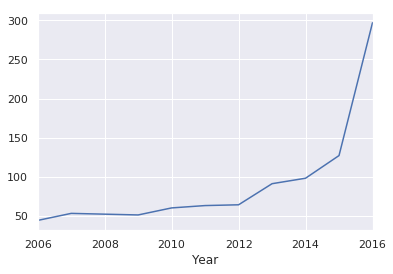

In [24]:
df['Rating_size'].plot();

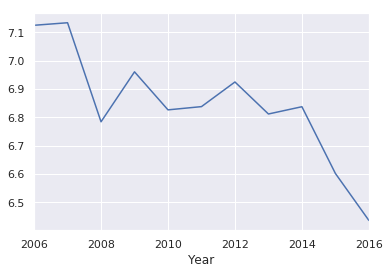

In [25]:
df['Rating_mean'].plot();

### Query: Find the Highest Rated Directors with at Least 3 Movies

In [13]:
# groupby director and aggregate by size and mean
df = movies.groupby('Director').agg({'Rating':['size', 'mean']})
df.columns = flatten_columns(df)
df.head(3)

,Rating_size,Rating_mean
Director,,
Aamir Khan,1,8.5
Abdellatif Kechiche,1,7.8
Adam Leon,1,6.5


In [14]:
# directors with at least 3 movies
directors =  df[df['Rating_size'] >= 3]

# sort and display the top 5 by mean rating
highest_rated = directors.nlargest(n=5,columns='Rating_mean')
highest_rated

,Rating_size,Rating_mean
Director,,
Christopher Nolan,5,8.68
Martin Scorsese,5,7.92
Quentin Tarantino,4,7.90
Wes Anderson,3,7.90
David Fincher,5,7.82


### Plot: Movie Ratings vs Director for Above Directors

In [28]:
df = movies[movies['Director'].isin(highest_rated.index)]

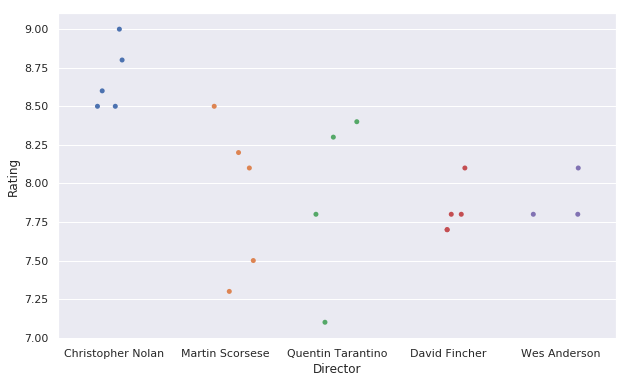

In [44]:
# there are too few movies per director for a good blox plot, use stripplot
plt.figure(figsize=(10,6))
sns.stripplot(x='Director', y='Rating', data=df, jitter=0.25);